In [1]:
import numpy as np

import scipy.io
import os.path

from pprint import pprint

import matplotlib.pyplot as plt

Define classes to keep the data.

In [2]:
def strictly_increasing(seq):
    """Checks whether input list is strictly increasing.
    """
    return all(x < y for x, y in zip(seq, seq[1:]))

class Trajectory:
    """Class which holds the data for a single trajectory.

    Contains the recorded points in time and the corresponding coordinates.
    Further quantities derived from this data is caluclated by the class.
    Input data needs to be in chronological order.

    Args:
        t_traj: nt array of floats. Points in time.
        r_traj: nt x sd array of floats. Coordinates. If r is a 1D array,
            sd==1 is assumed and the additional dimension is forced.

    Attributes:
        mdd:    dictionary containing metadata.

    Properties:
        t:      nt array of floats. Recording times
        r:      nt x sd array of floats. Coordinates.
        dr:  nt-1 x sd array of floats. Displacement vectors.
        dr:     nt-1 array of floats. Absolute values of displacement vectors.
        v:   nt-1 x sd array of floats. Average vectorial velocity between
                data points.
        v:      nt-1 array of floats. Absolute values of velocity between
                data points.
        nt:     int. Number of data points in trajectory.
        spatial_dims: int. Number of spatial dimensions.
        tr_wo_nan: array of floats. Data without nan data.

    Methods:
        TAMSD:  nt-1 array of floats. Time averaged MSD.

    """

    def __init__(self, t_traj, r_traj, metadata_dict=None):
        assert len(t_traj) == len(r_traj), ("lengths of t and r input have to "
                                            "match.")
        assert strictly_increasing(t_traj), ("t_traj needs to be strictly "
                                                "increasing")
        self._t = t_traj
        # forcing r_traj to be 2D
        if r_traj.ndim == 1:
            self._r = r_traj[:, None]
        else:
            self._r = r_traj
        if metadata_dict is None:
            self.mdd = {}
        else:
            self.mdd = metadata_dict
        self._spatial_dims = np.shape(self._r)[1]
        self._nt = len(self._t)
        self._dt = None
        self._dr = None
        self._v = None
        self._dr_abs = None
        self._v_abs = None

    def __str__(self):
        output = ""
        if hasattr(self, 'metadata_dict'):
            output += str(self.metadata_dict) + "\n"
        output += "* times\tcoordinates\n"
        for i in range(self.nt):
            output += "\t" + str(self.t[i]) + '\t' + str(self.r[i]) + "\n"
        output += "* # of data points:   " + str(self.nt) + "\n"
        output += "* spatial dimensions: " + str(self.spatial_dims) + '\n'
        return output

    @property
    def t(self):
        """nt array of floats. Points in time."""
        return self._t

    @property
    def r(self):
        """nt x sd array of floats. Recorded coordinates."""
        return self._r

    @property
    def r_zero(self):
        """nt x sd array of floats. Coordinates shifted to start at (0,0)
        """
        return self._r - self._r[0]

    @property
    def dt(self):
        """nt-1 array of floats."""
        if self._dt is None:
            self._dt = self.t[1:] - self.t[:-1]
        return self._dt

    @property
    def nt(self):
        """int. Number of data points in trajectory."""
        return self._nt

    @property
    def dr(self):
        """nt-1 x sd array of floats. Displacement vectors.
        """
        if self._dr is None:
            self._dr = self.r[1:] - self.r[:-1]
        return self._dr

    @property
    def v(self):
        """nt-1 x sd array of floats. Average vectorial velocity between data
        points.
        """
        if self._v is None:
            dt = self.dt
            self._v = self.dr / np.repeat(dt[:, np.newaxis],
                                          self.spatial_dims, axis=1)
        return self._v

    @property
    def v_abs(self):
        """nt-1 array of floats. Absolute values of velocity between data
        points.
        """
        if self._v_abs is None:
            self._v_abs = np.sqrt(np.sum(self.v ** 2, axis=1))
        return self._v_abs

    @property
    def dr_abs(self):
        """nt-1 array of floats. Absolute values of displacement vectors."""
        if self._dr_abs is None:
            self._dr_abs = np.sqrt(np.sum(self.dr ** 2, axis=1))
        return self._dr_abs

    def TAMSD(self, dts):
        """
        """
        t = self.t
        r = self.r
        tamsd, numtrajs = get_tamsd(t, r, dts)

        return dts, tamsd, numtrajs

    @property
    def spatial_dims(self):
        """Int. Number of spatial dimensions. Depricated; use dim instead."""
        return self._spatial_dims

    @property
    def dim(self):
        """Int. Number of spatial dimensions."""
        return self._spatial_dims

    def check_equi_dt(self):
        """Returns the value of dt if all dt are equal.
        Returns 0 if they are not.
        """
        flag = np.all(np.isclose(self.dt[0], self.dt))
        if flag:
            return self.dt[0]
        else:
            return 0.0

    def get_experimental(self):
        return ExpTrajectory(self.t, self.r, self.mdd)

    def get_shortened_traj(self, nt):
        """Shortened version of the trajectory with nt data points only
        """
        assert nt <= self.nt
        straj = Trajectory(self.t[:nt], self.r[:nt], self.mdd)
        straj.mdd['modification'] = 'shortened'
        return straj

    def get_subsampled_traj(self, sparsity, sub_sample_ind):
        """Sparsed our version of the trajectory containing only every
        [sparsity]th data point of the trajectory starting from index
        [sub_sample_ind].

        """
        r = self.r[sub_sample_ind::sparsity]
        t = self.t[sub_sample_ind::sparsity]
        mdd = self.mdd
        mdd['sparsity'] = sparsity
        assert len(r) >=2
        sparse_traj = self.__class__(t, r, mdd)
        return sparse_traj


class ExpTrajectory(Trajectory):
    """Establishes a class for experimental trajectories. Adds the number of
    measurements with nan values as a property.
    """
    def __init__(self, t_traj, r_traj, metadata_dict=None):
        super().__init__(t_traj, r_traj, metadata_dict)
        self._n_nan = np.sum(np.isnan(np.sum(r_traj, axis=1)))
        self._t_wo_nan, self._r_wo_nan = self.tr_wo_nan

    @property
    def n_nan(self):
        """int. Number of position measurements that have nan value."""
        return self._n_nan

    @property
    def tr_wo_nan(self):
        """time points and positions with nan values removed.
        """
        t_nan = np.isnan(self.t)
        r_nan = np.any(np.isnan(self.r), axis=1)
        tr_nan = np.logical_or(t_nan, r_nan)
        return self.t[~tr_nan], self.r[~tr_nan]

    @property
    def t_wo_nan(self):
        return self._t_wo_nan

    @property
    def r_wo_nan(self):
        return self._r_wo_nan

    @property
    def dr_wo_nan(self):
        return self.r_wo_nan[1:] - self.r_wo_nan[:-1]

    @property
    def dt_wo_nan(self):
        return self.t_wo_nan[1:] - self.t_wo_nan[:-1]


class DataSet:
    """Class which holds sets of trajectories.
    Iterating over data set returns trajectories

    Args:
        traj_list. List of instances of trajectory.

    Properties:
        ntraj: int. Number of trajectories stored in the dataset.

    Attributes:
        mdd:   dict. Metadata of the dataset
    """

    def __init__(self, traj_list=[], metadata_dict=None, name='nn'):
        self._traj_list = traj_list

        self.calculated_displacements = False
        self.dt_list = None
        self.dr_list = None
        self.ntcum_list = None
        self.mdd = metadata_dict
        self._equi_dt = None  # equal equidistant dt for all trajs

        # ensure that all trajectories have identical number of spatial dims.
        if self.ntraj > 0:
            dims = [traj.spatial_dims for traj in traj_list]
            if not all(x == dims[0] for x in dims):
                raise ValueError("Trajectories must have identical spatial "
                                 "dimensions.")
            self._spatial_dims = dims[0]
        else:
            self._spatial_dims = 0

        # set name of dataset
        if self.mdd is None:
            self.mdd = {'ds_name': name}
        else:
            if 'ds_name' not in self.mdd.keys():
                self.mdd['ds_name'] = name

    def __str__(self):
        output = "Dataset containing {} trajectories.\n".format(self.ntraj)
        output += pprint(self.mdd)
        output += '\n'
        for i, traj in enumerate(self._traj_list):
            output += "Trajectory {}:\n".format(i)
            output += str(traj) + "\n"
        return output

    def __iter__(self):
        self._n = 0
        return self

    def __next__(self):
        if self._n < self.ntraj:
            i = self._n
            self._n += 1
            return self._traj_list[i]
        else:
            raise StopIteration

    @property
    def ntraj(self):
        """Number of trajectories in """
        return len(self._traj_list)

    @property
    def spatial_dims(self):
        """Depricated; use dim instead."""
        return self._spatial_dims

    def num_traj_with_len(self, length):
        """Return number of trajectories in DataSet with certain length."""
        nl = 0
        for traj in self:
            if traj.nt == length:
                nl += 1
        return nl

    @property
    def traj_lengths(self):
        ls = []
        for traj in self:
            ls.append(traj.nt)
        return ls

    @property
    def dim(self):
        """Int. Number of spatial dimensions."""
        return self._spatial_dims

    @property
    def traj_list(self):
        """The list of trajectories."""
        return self._traj_list

    @property
    def equi_dt(self):
        self.check_equi_dt()
        return self._equi_dt

    @property
    def minmax_t(self):
        """returns the first and last measurement point in time over the
        whole DataSet.
        """
        min_t_traj = []
        max_t_traj = []
        for traj in self:
            min_t_traj.append(np.min(traj.t))
            max_t_traj.append(np.max(traj.t))
        return np.min(min_t_traj), np.max(max_t_traj)

    def add_traj(self, traj):
        if not isinstance(traj, Trajectory):
            raise ValueError("Input must be instance of trajectory class.")
        # set spatial dims if it is the first trajectory.
        if self.spatial_dims == 0:
            self._spatial_dims = traj.spatial_dims
        else:
            if not self.spatial_dims == traj.spatial_dims:
                raise ValueError(
                    "Dataset has spatial dimension {} but new trajectory has "
                    "spatial dimension {}".format(
                        self.spatial_dims, traj.spatial_dims)
                )
        self._traj_list.append(traj)
        self.calculated_displacements = False
        self._equi_dt = None

    def get_traj_mdds(self):
        """Compiles a list of the individual metadata dicts of all
        trajectories.

        Returns:
             mdds: list of dicts. All dictionaries of trajectories.
        """
        mdds = []
        for i in range(self.ntraj):
            mdds.append(self._traj_list[i].mdd)
        return mdds

    def get_traj_by_ind(self, i):
        """Extract a trajectory by its index in traj_list.

        Returns:
            traj. Trajectory object.
        """
        return self._traj_list[i]

    def set_traj_ids(self):
        """Creates id tag for all trajectories.

        """
        for i, traj in enumerate(self):
            traj.mdd['id'] = i

    def check_equi_dt(self):
        """Checks if all trajectories have the same equidistant dt.
        Sets internal variable and returns result.
        If all trajectories have equidistant dt the value is returned.
        Otherwise -1 is returned.
        """
        dt = self.traj_list[0].dt[0]
        for traj in self.traj_list:
            # check if dt is equidistant within t_rajectory
            dt_traj = traj.check_equi_dt()
            # check if dt conincides with dt from last t_rajectory
            flag = np.isclose(dt, dt_traj)
            # check flags
            if not (dt_traj > 0 and flag):
                self._equi_dt = False
                return -1.0
        self._equi_dt = True
        return dt

    def EATAMSD(self, dts):
        """ensmeble averaged time averaged msd
        """
        sum_tamsd = np.zeros((self.ntraj, len(dts)))
        sum_numtrajs = np.zeros(len(dts))
        for i, traj in enumerate(self):
            print(i + 1)
            dts, tamsd, numtrajs = traj.TAMSD(dts)
            sum_tamsd[i] = numtrajs * tamsd
            sum_numtrajs += numtrajs
        return np.nansum(sum_tamsd, axis=0) / sum_numtrajs

Define functions to load data from file

In [3]:
def matlab2ds(filepath, data_name, colloid_size, time_unit='s'):
    """
    Arguments:
        filepath: str. Path to .mat file
        data_name: str. Name of the data struct in the .mat file
        colloid_size: float. Colloid size in the experiment.
        time_unit: str. either 's' or 'min'

    Returns:
         DataSet object. The data as loaded form the file
    """
    # read bare data from matlab
    data_bare = scipy.io.loadmat(filepath)

    # extract the matlab struct
    track_struct_matlab = data_bare[data_name]

    # loop over trajectories and create list with trajectories
    if time_unit == 's':
        frame = 15.0  # seconds
        time_unit_name = 'seconds'
    elif time_unit == 'min':
        frame = 0.25
        time_unit_name = 'minutes'
    else:
        raise ValueError('time_unit must be "s" or "min"')
    px = 1 / 1.56  # micrometers
    traj_list = []
    for i in range(len(track_struct_matlab.T)):
        traj_mat = track_struct_matlab[0, i]
        r_px = traj_mat[0]
        t_frames = traj_mat[1][:, 0] - 1 # Matlab is starts indexing at 1
        # handle cases in which no full t array is given.
        if len(t_frames) != len(r_px):
            # print('no full t_frame found.')
            t_frames = np.arange(len(r_px))
        r_um = r_px * px
        t_s = t_frames * frame
        mdd = {
            'colloid_size': colloid_size,
            'time_unit': time_unit_name,
            'space_unit': 'micrometer'
        }
        traj_list.append(ExpTrajectory(t_s, r_um, mdd))
    mdd_ds = {
        'datatype': 'experimental',
        'colloid_size': colloid_size,
        'time_unit': time_unit_name,
        'space_unit': 'micrometer',
        'time_unit_tex': '\\mathrm{{s}}',
        'space_unit_tex': '\\mathrm{{\\mu m}}'
    }
    ds = DataSet(traj_list, mdd_ds, 'Lara_{}um_colloids'.format(colloid_size))
    print('Loaded {} trajectories from file.'.format(ds.ntraj))
    return ds

def get_data(colloid_size):
    # define paths
    datadir = os.path.join('.')
    file_name = 'Tracks_{:.0f}um.mat'.format(colloid_size)
    data_name = 'data_mult{:.0f}'.format(colloid_size)
    # load data from file
    filepath = os.path.join(datadir, file_name)
    ds = matlab2ds(filepath, data_name, colloid_size)
    return ds

In [4]:
ds29 = get_data(29)
ds46 = get_data(46)
ds61 = get_data(61)
ds100 = get_data(100)

Loaded 266 trajectories from file.
Loaded 189 trajectories from file.
Loaded 177 trajectories from file.
Loaded 80 trajectories from file.


Plot for visualization

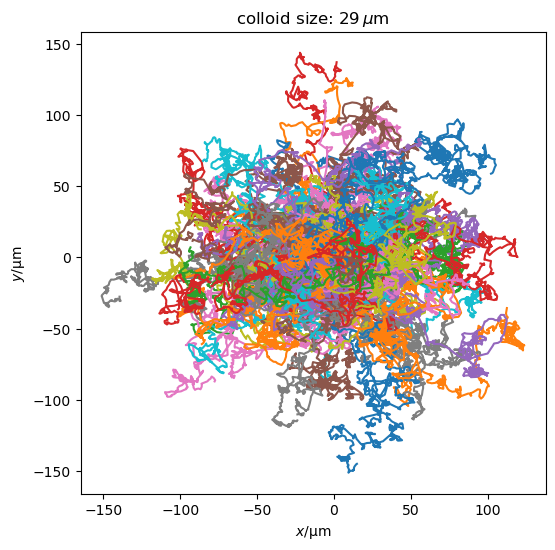

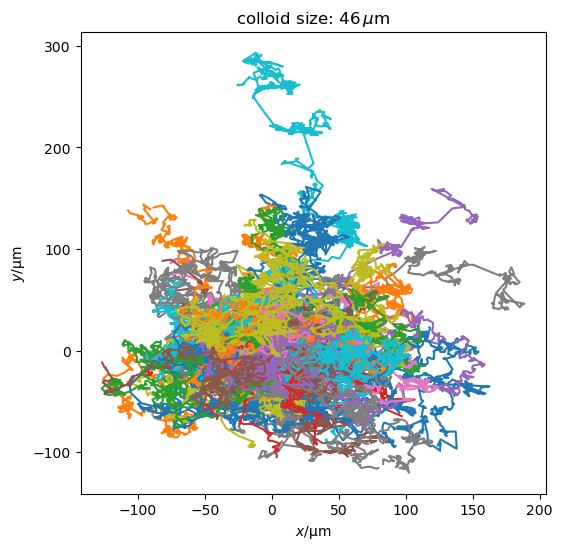

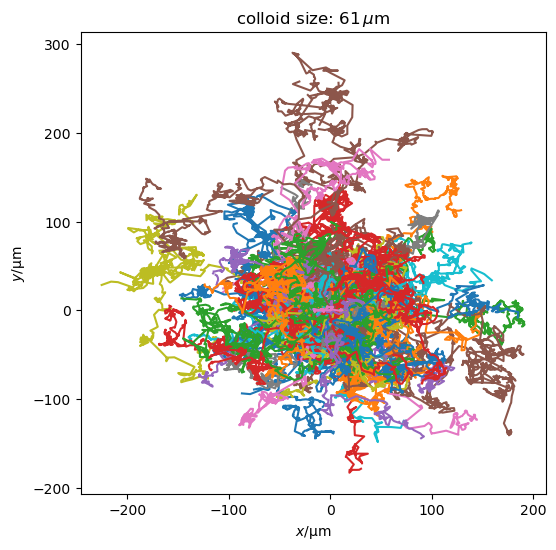

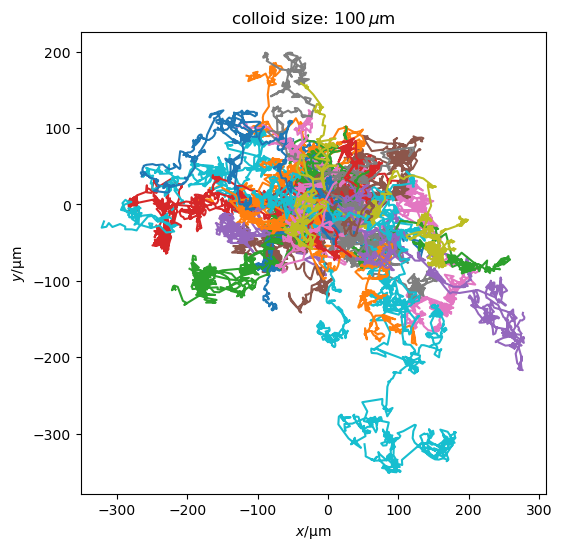

In [5]:
def plot_ds_all(ds, cs):
    fig, ax = plt.subplots(1,1, figsize = (6,6))
    for traj in ds:
        plt.plot(*traj.r_zero.T)
    ax.set_title('colloid size: ${}\\,\\mu\\mathrm{{m}}$'.format(cs))
    ax.set_xlabel('$x / {}$'.format(ds.mdd['space_unit_tex']))
    ax.set_ylabel('$y / {}$'.format(ds.mdd['space_unit_tex']))

plot_ds_all(ds29, 29)
plot_ds_all(ds46, 46)
plot_ds_all(ds61, 61)
plot_ds_all(ds100, 100)
